In [2]:
import os, sys
sys.path.append(os.path.abspath("../"))
import optuna
import numpy as np
import pandas as pd

from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

### CARGA DE DATASET Y DIVISIÓN TRAIN/TEST

In [235]:
# Se carga el dataset de trabajo
df = pd.read_csv("../data_sample/Datos_Reservas.csv")

# Se separa los conjuntos de datos de train y test
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 42)

# Se identifica el target
target = "canceled"

### TRANSFORMACIONES

In [236]:
# TRAIN
#---------------------------- CAMBIO 1-----------------------------------------
# ELIMINACIÓN DE REGISTROS DE PROMOCIONES, DEVOLUCIONES Y POSIBLES ERRORES
# TRANSFORMACIÓN LOGÍSTICA A LA COLUMNA 'daily_price'
train_set = train_set.drop(train_set[train_set["daily_price"] <= 0].index, axis = 0)
train_set = train_set.drop(train_set[train_set["daily_price"] > 2000].index, axis = 0)
train_set["daily_price"] = np.log10(train_set["daily_price"])
#---------------------------- CAMBIO 2-----------------------------------------
# ELIMINACIÓN DE VALORES INCONSISTENTES Y TRANSFORMACIÓN LOGÍSTICA A LA COLUMNA 'lead_time'
train_set = train_set.drop(train_set[train_set["lead_time"] <= 0].index, axis = 0)
train_set["lead_time"] = np.log10(train_set["lead_time"])
#---------------------------- CAMBIO 3-----------------------------------------
# ELIMINACIÓN DE REGISTROS CON VALOR 0 COINCIDENTES EN LAS COLUMNAS 'adults' Y 'children'
train_set = train_set.drop(train_set[(train_set["adults"] == 0)&(train_set["children"] == 0)].index, axis = 0)
#---------------------------- CAMBIO 4-----------------------------------------
# TRANSFORMACIÓN DE 'children' A CATEGÓRICA BINARIA
train_set.loc[train_set["children"] > 0, "children"] = 1
#---------------------------- CAMBIO 5-----------------------------------------
# TRANSFORMACIÓN DE 'total_book' A CATEGÓRICA BINARIA
train_set.loc[train_set["total_book"] > 0, "total_book"] = 1
#---------------------------- CAMBIO 6-----------------------------------------
# TRANSFORMACIÓN DE 'pre_cancel' A CATEGÓRICA BINARIA
train_set.loc[train_set["pre_cancel"] > 0, "pre_cancel"] = 1
#---------------------------- CAMBIO 7-----------------------------------------
# ELIMINACIÓN DE 'arr_date'
train_set.drop(columns = ["arr_date"], inplace = True)
#---------------------------- CAMBIO 8-----------------------------------------
# ELIMINACIÓN DE VALORES INCONSISTENTES COINCIDENTES EN LAS COLUMNAs 'week_nights' y 'weekend_nights'
# TRANSFORMACIÓN DE ETIQUETAS PARA UNIFICAR LOS VALORES POR ENCIMA DE 5 EN 'week_nights' Y POR ENCIMA DE 2 EN 'weekend_nights'
train_set = train_set.drop(train_set[(train_set["week_nights"] == 0)&(train_set["weekend_nights"] == 0)].index, axis = 0)
train_set.loc[train_set["week_nights"] > 5, "week_nights"] = 6
train_set.loc[train_set["weekend_nights"] > 2, "weekend_nights"] = 3
#---------------------------- CAMBIO 9-----------------------------------------
# TRANSFORMACIÓN DE 'meal_plan' A VARIABLE NUMÉRICA CON ORDINAL ENCODER
encoder = OrdinalEncoder(categories=[["SC","RO","BB","HB","FB"]])
train_set[["meal_plan"]] = encoder.fit_transform(train_set[["meal_plan"]])
#---------------------------- CAMBIO 10-----------------------------------------
# TRANSFORMACIÓN DE 'parking' A VARIABLE BINARIA
train_set.loc[train_set["parking"] > 0, "parking"] = 1


# TEST
#---------------------------- CAMBIO 1-----------------------------------------
# ELIMINACIÓN DE REGISTROS DE PROMOCIONES, DEVOLUCIONES Y POSIBLES ERRORES
# TRANSFORMACIÓN LOGÍSTICA A LA COLUMNA 'daily_price'
test_set = test_set.drop(test_set[test_set["daily_price"] <= 0].index, axis = 0)
test_set = test_set.drop(test_set[test_set["daily_price"] > 2000].index, axis = 0)
test_set["daily_price"] = np.log10(test_set["daily_price"])
#---------------------------- CAMBIO 2-----------------------------------------
# ELIMINACIÓN DE VALORES INCONSISTENTES Y TRANSFORMACIÓN LOGÍSTICA A LA COLUMNA 'lead_time'
test_set = test_set.drop(test_set[test_set["lead_time"] <= 0].index, axis = 0)
test_set["lead_time"] = np.log10(test_set["lead_time"])
#---------------------------- CAMBIO 3-----------------------------------------
# ELIMINACIÓN DE REGISTROS CON VALOR 0 COINCIDENTES EN LAS COLUMNAS 'adults' Y 'children'
test_set = test_set.drop(test_set[(test_set["adults"] == 0)&(test_set["children"] == 0)].index, axis = 0)
#---------------------------- CAMBIO 4-----------------------------------------
# TRANSFORMACIÓN DE 'children' A CATEGÓRICA BINARIA
test_set.loc[test_set["children"] > 0, "children"] = 1
#---------------------------- CAMBIO 5-----------------------------------------
# TRANSFORMACIÓN DE 'total_book' A CATEGÓRICA BINARIA
test_set.loc[test_set["total_book"] > 0, "total_book"] = 1
#---------------------------- CAMBIO 6-----------------------------------------
# TRANSFORMACIÓN DE 'pre_cancel' A CATEGÓRICA BINARIA
test_set.loc[test_set["pre_cancel"] > 0, "pre_cancel"] = 1
#---------------------------- CAMBIO 7-----------------------------------------
# ELIMINACIÓN DE 'arr_date'
test_set.drop(columns = ["arr_date"], inplace = True)
#---------------------------- CAMBIO 8-----------------------------------------
# ELIMINACIÓN DE VALORES INCONSISTENTES COINCIDENTES EN LAS COLUMNAs 'week_nights' y 'weekend_nights'
# TRANSFORMACIÓN DE ETIQUETAS PARA UNIFICAR LOS VALORES POR ENCIMA DE 5 EN 'week_nights' Y POR ENCIMA DE 2 EN 'weekend_nights'
test_set = test_set.drop(test_set[(test_set["week_nights"] == 0)&(test_set["weekend_nights"] == 0)].index, axis = 0)
test_set.loc[test_set["week_nights"] > 5, "week_nights"] = 6
test_set.loc[test_set["weekend_nights"] > 2, "weekend_nights"] = 3
#---------------------------- CAMBIO 9-----------------------------------------
# TRANSFORMACIÓN DE 'meal_plan' A VARIABLE NUMÉRICA CON ORDINAL ENCODER
encoder = OrdinalEncoder(categories=[["SC","RO","BB","HB","FB"]])
test_set[["meal_plan"]] = encoder.fit_transform(test_set[["meal_plan"]])
#---------------------------- CAMBIO 10-----------------------------------------
# TRANSFORMACIÓN DE 'parking' A VARIABLE BINARIA
test_set.loc[test_set["parking"] > 0, "parking"] = 1

In [237]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79384 entries, 68579 to 15795
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   daily_price     79384 non-null  float64
 1   lead_time       79384 non-null  float64
 2   adults          79384 non-null  int64  
 3   children        79384 non-null  int64  
 4   repeated_guest  79384 non-null  int64  
 5   total_book      79384 non-null  int64  
 6   pre_cancel      79384 non-null  int64  
 7   arr_week        79384 non-null  int64  
 8   week_nights     79384 non-null  int64  
 9   weekend_nights  79384 non-null  int64  
 10  meal_plan       79384 non-null  float64
 11  parking         79384 non-null  int64  
 12  special_req     79384 non-null  int64  
 13  canceled        79384 non-null  int64  
dtypes: float64(3), int64(11)
memory usage: 9.1 MB


In [238]:
train_set.describe().T

,count,mean,std,min,25%,50%,75%,max
daily_price,79384.0,2.000724,0.197510,-0.585027,1.892095,2.005095,2.130334,2.705864
lead_time,79384.0,1.595461,0.632201,0.000000,1.230449,1.732394,2.089905,2.850646
adults,79384.0,1.909680,0.498848,0.000000,2.000000,2.000000,2.000000,4.000000
children,79384.0,0.102955,0.303902,0.000000,0.000000,0.000000,0.000000,1.000000
repeated_guest,79384.0,0.027210,0.162694,0.000000,0.000000,0.000000,0.000000,1.000000
total_book,79384.0,0.040915,0.198095,0.000000,0.000000,0.000000,0.000000,1.000000
pre_cancel,79384.0,0.016426,0.127110,0.000000,0.000000,0.000000,0.000000,1.000000
arr_week,79384.0,27.295085,13.503051,1.000000,16.000000,28.000000,38.000000,53.000000
week_nights,79384.0,2.561259,1.569603,0.000000,1.000000,2.000000,4.000000,6.000000
weekend_nights,79384.0,1.001562,0.913390,0.000000,0.000000,1.000000,2.000000,3.000000


### DIVISIÓN DE SUBCONJUNTOS X,Y

In [239]:
# Se forman los subconjuntos X,y
X_train = train_set.copy()
X_train.drop(columns = [target], inplace = True)
y_train = train_set[target].copy()

X_test = test_set.copy()
X_test.drop(columns = [target], inplace = True)
y_test = test_set[target].copy()

##### ESCALADO DE VARIABLES

In [240]:
# Se lleva a cabo un escalado de los valores para aplicar con los modelos sensibles a la distancia
scaler = StandardScaler()
features = X_train.columns.to_list()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = features)

In [222]:
X_train_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
daily_price,79384.0,1.101832e-15,1.000006,-13.091801,-0.549995,0.022131,0.656223,3.570164
lead_time,79384.0,-2.898238e-16,1.000006,-2.523677,-0.577371,0.216598,0.782105,1.985434
adults,79384.0,1.432113e-18,1.000006,-3.828204,0.181059,0.181059,0.181059,4.190322
children,79384.0,-6.627997e-17,1.000006,-0.338780,-0.338780,-0.338780,-0.338780,2.951772
repeated_guest,79384.0,-4.618564e-17,1.000006,-0.167244,-0.167244,-0.167244,-0.167244,5.979285
total_book,79384.0,6.766733e-17,1.000006,-0.206544,-0.206544,-0.206544,-0.206544,4.841579
pre_cancel,79384.0,1.682732e-17,1.000006,-0.129232,-0.129232,-0.129232,-0.129232,7.738042
arr_week,79384.0,-3.857754e-17,1.000006,-1.947356,-0.836489,0.052204,0.792782,1.903650
week_nights,79384.0,-7.093433e-17,1.000006,-1.631799,-0.994691,-0.357583,0.916633,2.190849
weekend_nights,79384.0,3.848803e-17,1.000006,-1.096539,-1.096539,-0.001710,1.093119,2.187948


### GENERACIÓN DE BASELINE

In [223]:
# Escalado (StandarScaler) aplicado a Logistic Regression
model_names = ["Logistic Regression","DecisionTree","Random Forest","XGBoost","LightGBM","CatBoost"]
clf_LR = LogisticRegression(max_iter = 10000)
clf_DT = DecisionTreeClassifier(random_state = 42)
clf_RF = RandomForestClassifier(random_state = 42)
clf_XG = XGBClassifier(random_state = 42)
clf_LG = LGBMClassifier(random_state = 42, verbose = -100)
clf_CA = CatBoostClassifier(random_state = 42, verbose = False)
model_set = [clf_LR, clf_DT, clf_RF, clf_XG, clf_LG, clf_CA]

metricas_cv = {}
valores = []
for name,model in zip(model_names, model_set):
    print(model)
    if name != "Logistic Regression":
        metricas_cv[name] = cross_val_score(model, X_train, y_train, cv = 5, scoring = "balanced_accuracy")
    else:
        metricas_cv[name] = cross_val_score(model, X_train_scaled, y_train, cv = 5, scoring = "balanced_accuracy")
    valores.append(np.mean(metricas_cv[name]))
ganador = list(metricas_cv.keys())[np.argmax(valores)]

for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, Accuracy_CV: {np.mean(valores)}")
print(f"El modelo con mejor métrica es {ganador}")

LogisticRegression(max_iter=10000)
DecisionTreeClassifier(random_state=42)
RandomForestClassifier(random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)
LGBMClassifier(random_state=42, verbose=-100)
Model <Logistic Regression>, Accuracy_CV: 0.6337755329239982
Model <DecisionTr

              precision    recall  f1-score   support

           0       0.83      0.89      0.86     13904
           1       0.70      0.58      0.64      5959

    accuracy                           0.80     19863
   macro avg       0.77      0.74      0.75     19863
weighted avg       0.79      0.80      0.79     19863



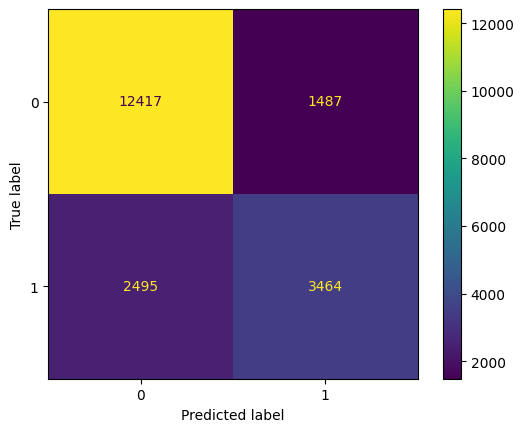

In [224]:
# Entrenar modelo
clf_RF.fit(X_train, y_train)

# Realizar predicciones y evaluar el modelo
y_pred_RF = clf_RF.predict(X_test)
print(classification_report(y_test, y_pred_RF))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_RF);

### BALANCEO DE TARGET

              precision    recall  f1-score   support

           0       0.88      0.74      0.81     13904
           1       0.56      0.77      0.65      5959

    accuracy                           0.75     19863
   macro avg       0.72      0.75      0.73     19863
weighted avg       0.78      0.75      0.76     19863



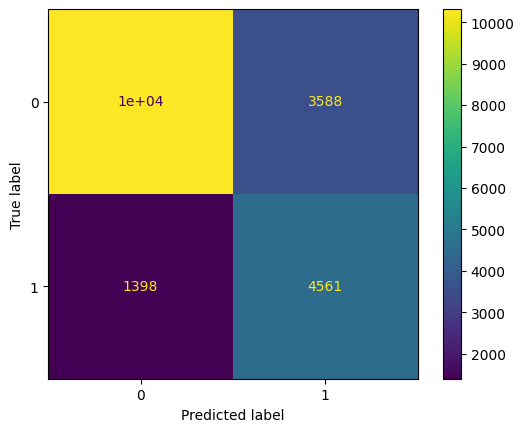

In [225]:
# Se balancea el target empleando un undersampling (resample)

feature_w = X_train[y_train == 0]
feature_l = X_train[y_train == 1]
feature_w_us = resample(feature_w, replace = False, n_samples = len(feature_l), random_state = 42)
X_train_us = pd.concat([feature_w_us, feature_l])
y_train_us = pd.concat([y_train.loc[feature_w_us.index], y_train.loc[feature_l.index]])

# Entrenar el modelo con los datos bajomuestreados
clf_RF_us = RandomForestClassifier(random_state = 42)
clf_RF_us.fit(X_train_us, y_train_us)

# Realizar predicciones y evaluar el modelo
y_pred_RF_us = clf_RF_us.predict(X_test)
print(classification_report(y_test, y_pred_RF_us))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_RF_us);

              precision    recall  f1-score   support

           0       0.83      0.89      0.86     13904
           1       0.70      0.58      0.64      5959

    accuracy                           0.80     19863
   macro avg       0.77      0.74      0.75     19863
weighted avg       0.79      0.80      0.79     19863



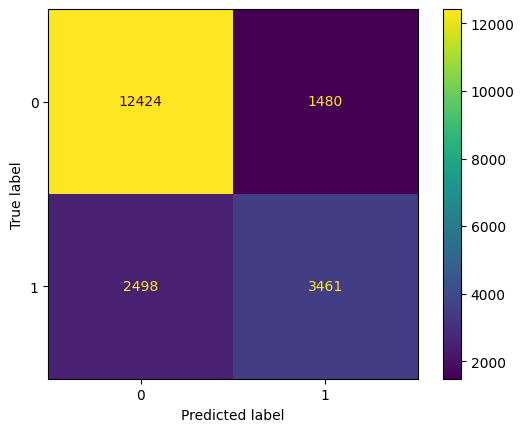

In [226]:
# Se balancea el target empleando 'class_weight'

# Entrenar el modelo indicando 'class_weight'
clf_RF_cw = RandomForestClassifier(random_state = 42, class_weight = "balanced")
clf_RF_cw.fit(X_train, y_train)

# Realizar predicciones y evaluar el modelo
y_pred_RF_cw = clf_RF_cw.predict(X_test)
print(classification_report(y_test, y_pred_RF_cw))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_RF_cw);

### AJUSTE DE PARÁMETOS

In [ ]:
# Optimización de parámetros mediante Optuna

def objective(trial):
    # Suggest values for hyperparameters
    criterion = trial.suggest_categorical("criterion", ["gini","entropy","log_loss"])
    n_estimators = trial.suggest_int("n_estimators", 10, 1000, log = True)
    max_depth = trial.suggest_int("max_depth", 2, 32)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    # Create and fit random forest model
    model = RandomForestClassifier(
        criterion = criterion,
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_samples_split = min_samples_split,
        min_samples_leaf = min_samples_leaf,
        random_state = 42,
        )
        
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [91]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)

print(f"Best parameters: {study.best_params}")
print(f"Best score: {study.best_value}")

[I 2025-06-30 16:08:23,391] A new study created in memory with name: no-name-47cb5f98-cd75-4eea-9838-a3018711022e
[I 2025-06-30 16:08:32,734] Trial 0 finished with value: 0.7711826008155868 and parameters: {'criterion': 'entropy', 'n_estimators': 211, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.7711826008155868.
[I 2025-06-30 16:08:35,013] Trial 1 finished with value: 0.7806474349292655 and parameters: {'criterion': 'gini', 'n_estimators': 45, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.7806474349292655.
[I 2025-06-30 16:08:35,537] Trial 2 finished with value: 0.7606101797311584 and parameters: {'criterion': 'gini', 'n_estimators': 19, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.7806474349292655.
[I 2025-06-30 16:08:37,579] Trial 3 finished with value: 0.7396163721492222 and parameters: {'criterion': 'log_loss', 'n_estimators': 99, 'ma

Best parameters: {'criterion': 'log_loss', 'n_estimators': 290, 'max_depth': 31, 'min_samples_split': 3, 'min_samples_leaf': 1}
Best score: 0.8004833106781453


              precision    recall  f1-score   support

           0       0.88      0.74      0.81     13904
           1       0.56      0.77      0.65      5959

    accuracy                           0.75     19863
   macro avg       0.72      0.75      0.73     19863
weighted avg       0.79      0.75      0.76     19863



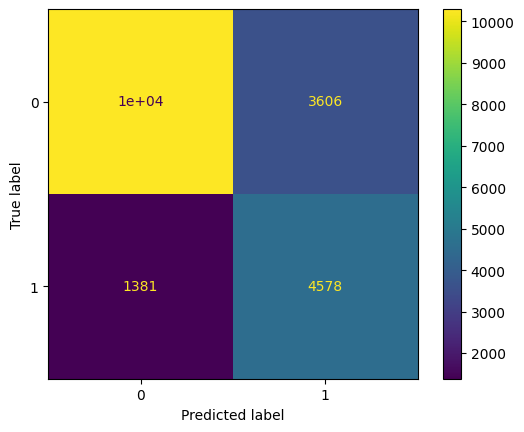

In [227]:
# Entrenar el modelo indicando los mejores parámetros
clf_RF_op = RandomForestClassifier(criterion = "log_loss", n_estimators = 290, max_depth = 31, min_samples_split = 3, min_samples_leaf = 1, random_state = 42)
clf_RF_op.fit(X_train_us, y_train_us)

# Realizar predicciones y evaluar el modelo
y_pred_RF_op = clf_RF_op.predict(X_test)
print(classification_report(y_test, y_pred_RF_op))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_RF_op);

In [229]:
# Optimización de parámetros por GridSearchCV

parameters = {
    "n_estimators": [100,200,300],
    "max_depth": [None],
    "min_samples_leaf": [1,2,4],
    "min_samples_split": [2,5,10],
    "max_features": ["sqrt","log2",None]}

grid_RF = GridSearchCV(clf_RF,
                       param_grid = parameters,
                       cv = 5,
                       scoring = "balanced_accuracy",
                       n_jobs = -1)

0.7303632985163672
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
              precision    recall  f1-score   support

           0       0.84      0.88      0.86     13904
           1       0.69      0.60      0.64      5959

    accuracy                           0.80     19863
   macro avg       0.76      0.74      0.75     19863
weighted avg       0.79      0.80      0.80     19863



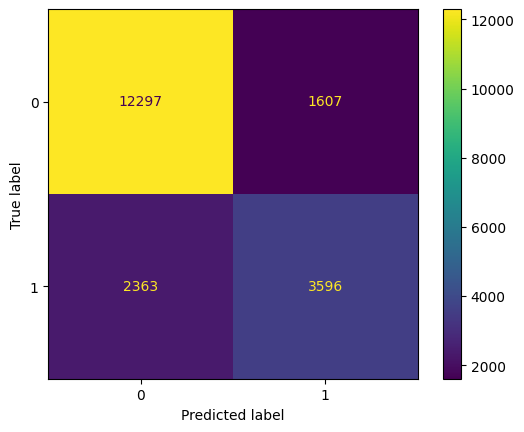

In [230]:
# Entrenar el modelo indicando los mejores parámetros
grid_RF.fit(X_train, y_train)
print(grid_RF.best_score_)
print(grid_RF.best_params_)

# Realizar predicciones y evaluar el modelo
y_pred_RF_gs = grid_RF.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_RF_gs))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_RF_gs)

### REPLANTEAMIENTO DE FEATURES

In [241]:
# Se descarta la variable 'arr_week', que mostró poca relación estadística con el 'target'
X_train2 = X_train.copy()
X_train2.drop(columns = ["arr_week"], inplace = True)

X_test2 = X_test.copy()
X_test2.drop(columns = ["arr_week"], inplace = True)

              precision    recall  f1-score   support

           0       0.83      0.88      0.85     13904
           1       0.67      0.57      0.61      5959

    accuracy                           0.79     19863
   macro avg       0.75      0.72      0.73     19863
weighted avg       0.78      0.79      0.78     19863



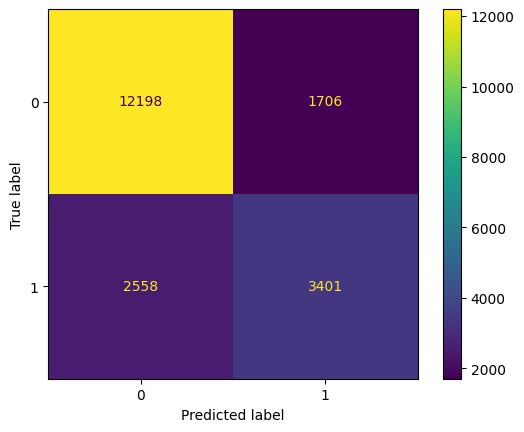

In [244]:
# Entrenar modelo
clf_RF.fit(X_train2, y_train)

# Realizar predicciones y evaluar el modelo
y_pred2_RF = clf_RF.predict(X_test2)
print(classification_report(y_test, y_pred2_RF))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred2_RF);

In [259]:
clf_RF_rf = RandomForestClassifier(max_depth = None, max_features = None, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 300, random_state = 42)
features = X_train.columns.to_list()

rfe = RFE(estimator = clf_RF_rf, n_features_to_select = 12, step = 1)
rfe.fit(X_train, y_train)
print(rfe.ranking_)
pd.DataFrame(rfe.ranking_, columns = ["ranking"], index = features).sort_values("ranking")

[1 1 1 1 1 2 1 1 1 1 1 1 1]


,ranking
daily_price,1
lead_time,1
adults,1
children,1
repeated_guest,1
pre_cancel,1
arr_week,1
week_nights,1
special_req,1
weekend_nights,1


In [260]:
rfe.transform(X_train)
X_train_rfe = pd.DataFrame(rfe.transform(X_train), columns = rfe.get_feature_names_out())
features_sel = X_train_rfe.columns.to_list()
X_test_rfe = X_test[features_sel]

              precision    recall  f1-score   support

           0       0.83      0.90      0.86     13904
           1       0.70      0.58      0.64      5959

    accuracy                           0.80     19863
   macro avg       0.77      0.74      0.75     19863
weighted avg       0.79      0.80      0.79     19863



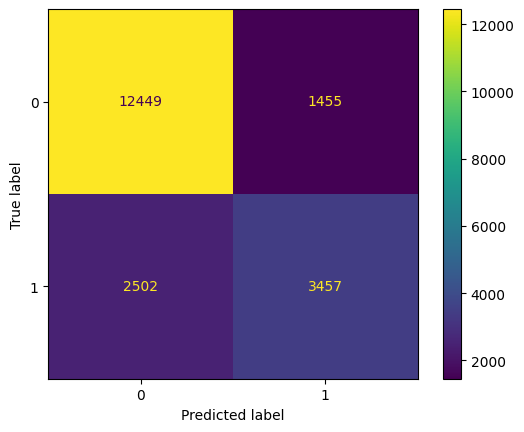

In [261]:
# Entrenar modelo
clf_RF.fit(X_train_rfe, y_train)

# Realizar predicciones y evaluar el modelo
y_pred_RF_rfe = clf_RF.predict(X_test_rfe)
print(classification_report(y_test, y_pred_RF_rfe))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_RF_rfe);

[1 1 1 1 2 3 1 1 1 1 1 1 1]
              precision    recall  f1-score   support

           0       0.83      0.89      0.86     13904
           1       0.70      0.58      0.63      5959

    accuracy                           0.80     19863
   macro avg       0.76      0.74      0.75     19863
weighted avg       0.79      0.80      0.79     19863



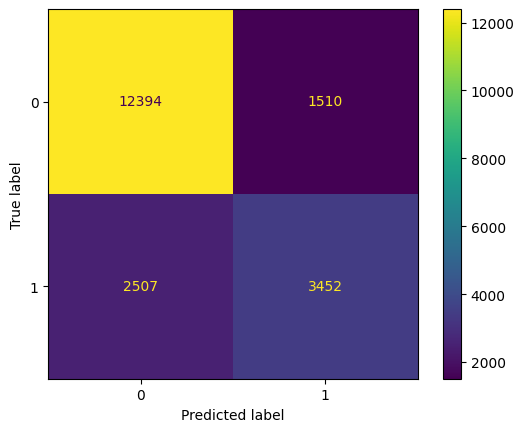

In [262]:
clf_RF_rf = RandomForestClassifier(max_depth = None, max_features = None, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 300, random_state = 42)
features = X_train.columns.to_list()

rfe = RFE(estimator = clf_RF_rf, n_features_to_select = 11, step = 1)
rfe.fit(X_train, y_train)
print(rfe.ranking_)
pd.DataFrame(rfe.ranking_, columns = ["ranking"], index = features).sort_values("ranking")

rfe.transform(X_train)
X_train_rfe = pd.DataFrame(rfe.transform(X_train), columns = rfe.get_feature_names_out())
features_sel = X_train_rfe.columns.to_list()
X_test_rfe = X_test[features_sel]

# Entrenar modelo
clf_RF.fit(X_train_rfe, y_train)

# Realizar predicciones y evaluar el modelo
y_pred_RF_rfe = clf_RF.predict(X_test_rfe)
print(classification_report(y_test, y_pred_RF_rfe))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_RF_rfe);

[1 1 1 2 3 4 1 1 1 1 1 1 1]
              precision    recall  f1-score   support

           0       0.83      0.89      0.86     13904
           1       0.70      0.59      0.64      5959

    accuracy                           0.80     19863
   macro avg       0.77      0.74      0.75     19863
weighted avg       0.79      0.80      0.80     19863



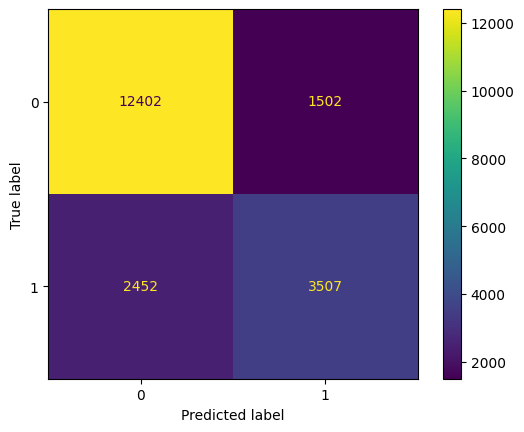

In [263]:
clf_RF_rf = RandomForestClassifier(max_depth = None, max_features = None, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 300, random_state = 42)
features = X_train.columns.to_list()

rfe = RFE(estimator = clf_RF_rf, n_features_to_select = 10, step = 1)
rfe.fit(X_train, y_train)
print(rfe.ranking_)
pd.DataFrame(rfe.ranking_, columns = ["ranking"], index = features).sort_values("ranking")

rfe.transform(X_train)
X_train_rfe = pd.DataFrame(rfe.transform(X_train), columns = rfe.get_feature_names_out())
features_sel = X_train_rfe.columns.to_list()
X_test_rfe = X_test[features_sel]

# Entrenar modelo
clf_RF.fit(X_train_rfe, y_train)

# Realizar predicciones y evaluar el modelo
y_pred_RF_rfe = clf_RF.predict(X_test_rfe)
print(classification_report(y_test, y_pred_RF_rfe))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_RF_rfe);

[1 1 1 3 4 5 2 1 1 1 1 1 1]
              precision    recall  f1-score   support

           0       0.83      0.89      0.86     13904
           1       0.69      0.57      0.62      5959

    accuracy                           0.79     19863
   macro avg       0.76      0.73      0.74     19863
weighted avg       0.79      0.79      0.79     19863



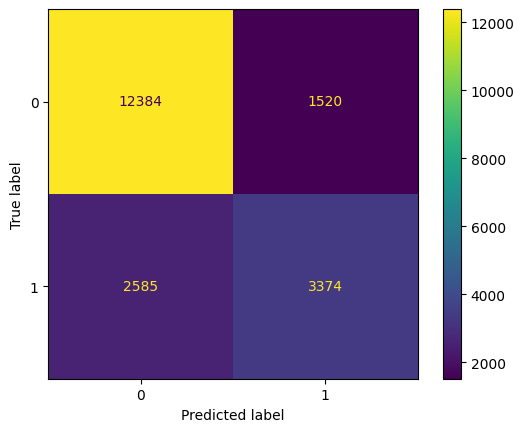

In [264]:
clf_RF_rf = RandomForestClassifier(max_depth = None, max_features = None, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 300, random_state = 42)
features = X_train.columns.to_list()

rfe = RFE(estimator = clf_RF_rf, n_features_to_select = 9, step = 1)
rfe.fit(X_train, y_train)
print(rfe.ranking_)
pd.DataFrame(rfe.ranking_, columns = ["ranking"], index = features).sort_values("ranking")

rfe.transform(X_train)
X_train_rfe = pd.DataFrame(rfe.transform(X_train), columns = rfe.get_feature_names_out())
features_sel = X_train_rfe.columns.to_list()
X_test_rfe = X_test[features_sel]

# Entrenar modelo
clf_RF.fit(X_train_rfe, y_train)

# Realizar predicciones y evaluar el modelo
y_pred_RF_rfe = clf_RF.predict(X_test_rfe)
print(classification_report(y_test, y_pred_RF_rfe))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_RF_rfe);

[1 1 1 4 5 6 3 1 1 1 1 2 1]
              precision    recall  f1-score   support

           0       0.82      0.89      0.85     13904
           1       0.68      0.54      0.60      5959

    accuracy                           0.78     19863
   macro avg       0.75      0.71      0.72     19863
weighted avg       0.77      0.78      0.78     19863



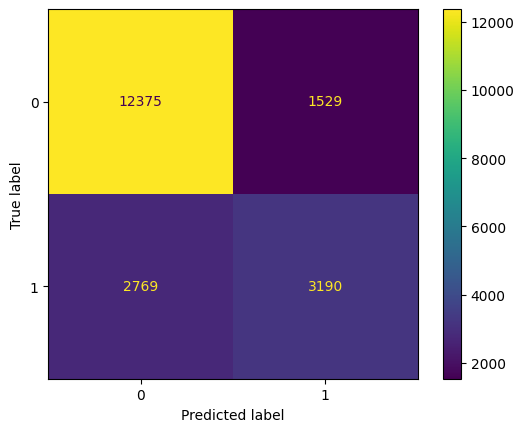

In [265]:
clf_RF_rf = RandomForestClassifier(max_depth = None, max_features = None, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 300, random_state = 42)
features = X_train.columns.to_list()

rfe = RFE(estimator = clf_RF_rf, n_features_to_select = 8, step = 1)
rfe.fit(X_train, y_train)
print(rfe.ranking_)
pd.DataFrame(rfe.ranking_, columns = ["ranking"], index = features).sort_values("ranking")

rfe.transform(X_train)
X_train_rfe = pd.DataFrame(rfe.transform(X_train), columns = rfe.get_feature_names_out())
features_sel = X_train_rfe.columns.to_list()
X_test_rfe = X_test[features_sel]

# Entrenar modelo
clf_RF.fit(X_train_rfe, y_train)

# Realizar predicciones y evaluar el modelo
y_pred_RF_rfe = clf_RF.predict(X_test_rfe)
print(classification_report(y_test, y_pred_RF_rfe))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_RF_rfe);

## CONCLUSIONES

El mejor resultado se obtiene con una selección de 10 variables, aplicada a un modelo RandomForestClassifier.  
Sin embargo, los resultados no son muy diferentes si se emplean todas las variables y se indica la opción 'balanced' en el 'class_weight' del modelo, o incluso si se entrena el modelo sin optimización de hiperparámetros o features.  
En ninguno de los casos se ha superado el 80% de accuracy.